## XRD Modeling

In [1]:
import pandas as pd

In [2]:
xrd_df = pd.read_csv('xrd_dataset.csv')

In [3]:
display(xrd_df)

,mp_id,formula,composition,crystal_system,symmetry_symbol,volume,density,xray_peaks,xray_intensities
0,mp-1005,FeP,"{'Fe': 1, 'P': 1}",Orthorhombic,Pnma,90.583862,6.366076,[23.15086164 31.02195798 33.23866128 34.822846...,[4.73131274e+00 1.76544138e+01 7.14334109e+01 ...
1,mp-1006367,Ce2HfSe5,"{'Ce': 2, 'Hf': 1, 'Se': 5}",Orthorhombic,Pnma,785.754385,7.215011,[13.59855865 14.68007171 15.5587516 17.216162...,[9.04260718e+00 3.88889592e+00 1.48704078e+01 ...
2,mp-1001606,LuFeC2,"{'Lu': 1, 'Fe': 1, 'C': 2}",Orthorhombic,Amm2,45.919844,9.215206,[24.87354653 25.79708699 30.23085522 36.139916...,[ 39.06976227 9.24752455 24.85129267 100. ...
3,mp-1001613,LuGa,"{'Lu': 1, 'Ga': 1}",Orthorhombic,Cmcm,87.819318,9.253483,[16.89543051 22.68791393 28.22757053 32.128373...,[5.68120675e-01 9.04300155e+00 2.95353313e+01 ...
4,mp-1008624,YBiPd,"{'Y': 1, 'Bi': 1, 'Pd': 1}",Cubic,F-43m,74.987877,8.952998,[23.01240126 26.63332165 38.0207848 44.910730...,[ 36.27131039 27.19850555 100. 19.56...
...,...,...,...,...,...,...,...,...,...
16423,mp-1213830,Ce3W(ClO2)3,"{'Ce': 3, 'W': 1, 'Cl': 3, 'O': 6}",Hexagonal,P6_3/m,408.805926,6.552238,[10.94822859 19.02128174 19.71983192 21.998023...,[5.40912233e+01 1.50813133e+00 2.77921414e+00 ...
16424,mp-1191620,PuB4Ru,"{'Pu': 1, 'B': 4, 'Ru': 1}",Orthorhombic,Pbam,244.423386,10.552355,[15.29269094 16.67763625 21.34936852 25.258563...,[2.17205238e+00 6.61441181e+00 2.08615588e+01 ...
16425,mp-1209360,Pr5Bi3Br,"{'Pr': 5, 'Bi': 3, 'Br': 1}",Hexagonal,P6_3/mcm,552.581472,8.482577,[10.53062158 18.29148783 21.1515142 22.538613...,[3.24368270e+00 2.33769877e+00 8.04064192e-01 ...
16426,mp-1190710,Sc5(In2Co)2,"{'Sc': 5, 'In': 4, 'Co': 2}",Orthorhombic,Pbam,440.878854,6.040735,[10.18858728 12.69727266 15.48118582 19.264295...,[1.37660375e+00 4.27657761e-02 1.92963728e+00 ...


In [4]:
import ast # <- parses Python literals from text

# Generate a list of elements in the dataset:
ELEMENTS = set()
for v in xrd_df['composition'].values:
    ELEMENTS |= set(ast.literal_eval(v).keys())
ELEMENTS = sorted(ELEMENTS)

# Generate a list of the crystal systems in the dataset:
CRYSTAL_SYSTEMS = sorted(set(xrd_df['crystal_system']))

# Generate a list of the symmetry symbols:
SYMM_SYMBOLS = sorted(set(xrd_df['symmetry_symbol']))

# print the sizes of ELEMENTS and CRYSTAL_SYSTEMS
print('Number of elements:', len(ELEMENTS))
print('Number of symmetry symbols:', len(ELEMENTS))
print('Number of crystal systems:', len(CRYSTAL_SYSTEMS))

Number of elements: 85
Number of symmetry symbols: 85
Number of crystal systems: 7


In [11]:
import re
import matplotlib.pyplot as plt

def parse_xrd_data(row):
    peaks_str = re.sub(r'\s+', ',', row['xray_peaks'].strip(' []'))
    ints_str = re.sub(r'\s+', ',', row['xray_intensities'].strip(' []'))
    peaks = ast.literal_eval(peaks_str)
    ints = ast.literal_eval(ints_str)
    return peaks, ints
    
def plot_xrd(peaks, intensities):
    
    plt.figure()
    for x, y in zip(peaks, intensities):
        plt.plot([x,x], [0, y], color='b', linewidth=2)
    
    plt.axhline(color='b')
    plt.xlim((0,180))
    plt.grid()
    plt.ylabel('Intensity')
    plt.xlabel(r'Diffraction Angle $\theta / 2$')
    plt.show()

In [13]:
from mp_api.client import MPRester
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm
import numpy as np

xrd_df_clean = xrd_df.copy()

# with MPRester(mute_progress_bars=True) as mpr:

#     for i, row in tqdm(xrd_df.iterrows(), total=len(xrd_df)):

#         mpid = row['mp_id']
#         structure = mpr.get_structure_by_material_id(mpid)

#         if isinstance(structure, list):
#             structure = list[0]

#         # important to use the conventional structure to ensure
#         # that peaks are labelled with the conventional Miller indices
#         sga = SpacegroupAnalyzer(structure)
#         conventional_structure = sga.get_conventional_standard_structure()

#         # this example shows how to obtain an XRD diffraction pattern
#         # these patterns are calculated on-the-fly from the structure
#         calculator = XRDCalculator(wavelength="CuKa")
#         pattern = calculator.get_pattern(
#             conventional_structure, two_theta_range=(0,180))
#         peaks = np.array(pattern.x).tolist()
#         intensities = np.array(pattern.y).tolist()

#         xrd_df_clean.at[i, 'xray_peaks'] = str(peaks)
#         xrd_df_clean.at[i, 'xray_intensities'] = str(intensities)


In [8]:
xrd_df_clean.to_csv('xrd_dataset_clean.csv', index=False)

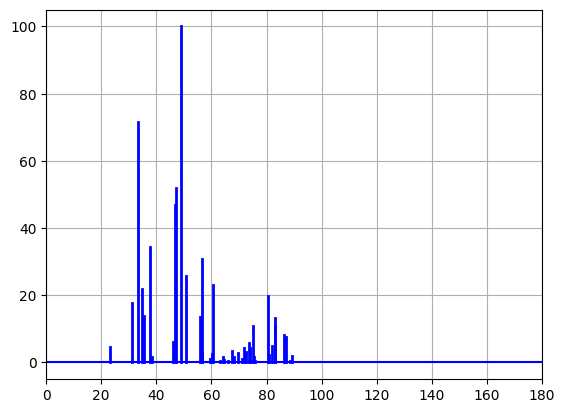

In [9]:
plot_xrd(*parse_xrd_data(xrd_df.iloc[0]))

In [10]:
import numpy as np

def vectorize_composition(composition, elements):
    """ converts an elemental composition dict to a vector. """
    total_n = sum(composition.values())
    vec = np.zeros(len(elements))
    for elem, n in composition.items():
        if elem in elements:
            vec[elements.index(elem)] = n/total_n
    return vec

def vectorize_crystal_system(crystal_system, systems):
    """ converts a crystal system to a vector. """
    vec = np.zeros(len(systems))
    if crystal_system in systems:
        vec[systems.index(crystal_system)] = 1.0
        
    return vec

def vectorize_symmetry(symmetry_symbol, symbols):
    """ converts a symmetry symbol to a vector. """
    vec = np.zeros(len(symbols))
    if symmetry_symbol in symbols:
        vec[symbols.index(symmetry_symbol)] = 1.0
        

In [ ]:
def vectorize_xrd_spectrum(peaks, intensities, intensity_scale=100, bins=180):
    hist, _ = np.histogram(
        peaks, bins=bins,
        range=(0, 90),
        weights=intensities)
    
    return hist / max_intensity

In [ ]:
def parse_data_vector(row):
    """ parses x and y vectors from a dataframe row """
    
    # parse the xray peaks and intensities
    peaks_str = re.sub(r'\s+', ',', row['xray_peaks'].strip(' []'))
    ints_str = re.sub(r'\s+', ',', row['xray_intensities'].strip(' []'))
    
    peaks = ast.literal_eval(peaks_str)
    ints = ast.literal_eval(ints_str)
        
    # parse the composition dict:
    composition_dict = ast.literal_eval(row['composition'])
    
    # parse feature vector (x):
    x_vector = np.concatenate([
        vectorize_composition(composition_dict, ELEMENTS),
        
        np.array([ row['density'] ]),
    ])
    
    # parse label vector (y):
    y_vector = np.concatenate([
        np.array([ row['band_gap'] ]),
        np.array([ bandgap_direct ])
    ])
    
    return x_vector, y_vector